**Daily etherium cost analysis**


In [38]:
import copy
import datetime
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sm as sm

from tqdm import tqdm

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Source: https://scikit-learn.org/stable/install.html
from interactor.sarima_interactor import SarimaInteractor

%matplotlib inline
light_blue_color = color_for_origin = '#23A1D7'
orange_color = color_for_train = 'orange'
pink_red_color = color_for_test = '#E52659'

In [39]:
df = pd.read_csv('data/Etherium.csv')
df.head(15)

,Date,Closing,Opening,High,Low,Volume,Diff %
0,12.02.2023,1543.00,1538.34,1547.30,1523.47,262820.00,0.3000
1,11.02.2023,1538.34,1513.12,1542.64,1508.07,306240.00,1.62000
2,10.02.2023,1513.82,1545.35,1554.19,1499.49,523330.00,-2.04000
3,09.02.2023,1545.35,1650.97,1655.96,1530.98,702210.00,-6.4000
4,08.02.2023,1650.99,1671.39,1694.28,1631.15,447570.00,-1.22000
5,07.02.2023,1671.40,1613.72,1676.83,1613.20,481910.00,3.57000
6,06.02.2023,1613.72,1629.44,1657.75,1606.59,401030.00,-0.96000
7,05.02.2023,1629.44,1666.90,1671.88,1612.70,435140.00,-2.25000
8,04.02.2023,1666.90,1663.78,1694.58,1646.11,328660.00,0.19000
9,03.02.2023,1663.79,1641.70,1673.59,1628.73,489790.00,1.34000


In [40]:
df.shape

(1139, 7)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1139 non-null   object 
 1   Closing  1139 non-null   float64
 2   Opening  1139 non-null   float64
 3   High     1139 non-null   float64
 4   Low      1139 non-null   float64
 5   Volume   1139 non-null   object 
 6   Diff %   1139 non-null   object 
dtypes: float64(4), object(3)
memory usage: 62.4+ KB


In [42]:
# Проанализируем базовые статистики имеющихся признаков
df.describe()

,Closing,Opening,High,Low
count,1139.000000,1139.000000,1139.000000,1139.000000
mean,1682.292774,1681.097489,1736.284241,1618.932397
std,1248.680995,1249.527143,1287.140512,1204.444383
min,107.900000,107.870000,117.910000,88.500000
25%,395.545000,395.420000,408.000000,383.865000
50%,1550.020000,1550.050000,1602.130000,1494.880000
75%,2631.325000,2631.085000,2748.645000,2543.090000
max,4808.380000,4808.340000,4864.060000,4715.430000


In [43]:
df = df.drop(['Closing', 'High', 'Low', 'Volume', 'Diff %'], axis=1)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1139 non-null   object 
 1   Opening  1139 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.9+ KB


In [45]:
# Привидём время к типу 'datetime' и сделаем его индексом для датасета
df['Date'] = df['Date'].str[:]
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.head(10)

,Opening
Date,
2020-01-01,129.21
2020-01-02,130.75
2020-01-03,127.19
2020-01-04,134.30
2020-01-05,134.32
2020-01-06,135.59
2020-01-07,144.09
2020-01-08,143.01
2020-01-09,140.80


*Method draws price plot*

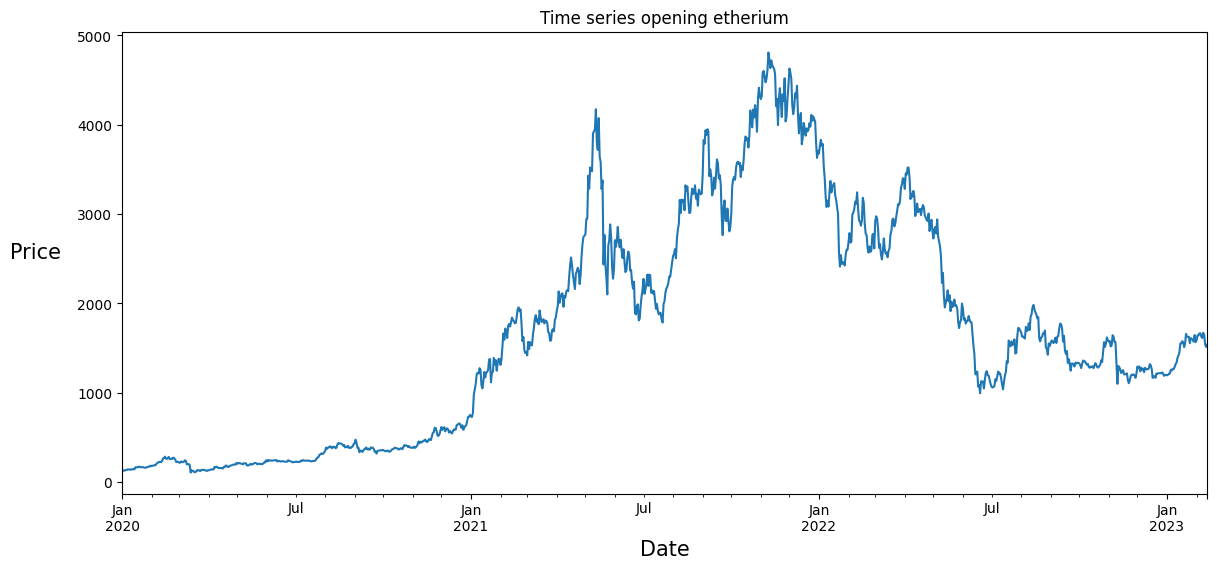

In [46]:
def draw_plot_price(rows, title):
    plt.figure(figsize=(14, 6))
    plt.title(title)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
    rows.plot()


draw_plot_price(df['Opening'], 'Time series opening etherium')

***Original Etherium opening graph***


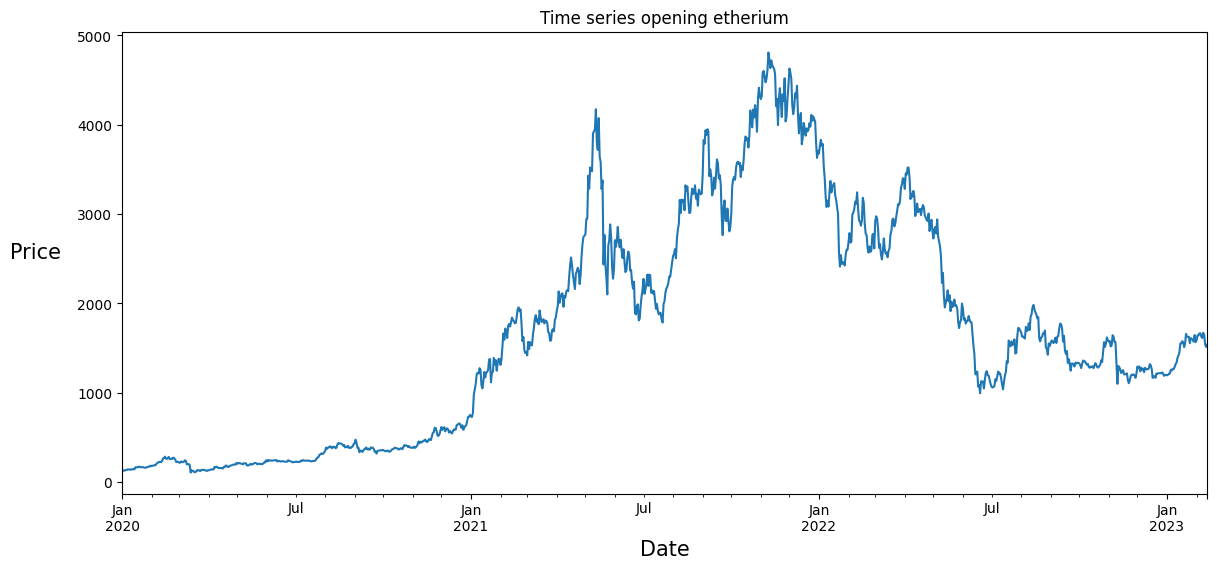

In [47]:
# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Time series opening etherium')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['Opening'].plot();

***Resample to monthly interval***


In [48]:
weekly_resampled_df = df.resample('7D').agg({'Opening': 'first'})
weekly_resampled_df

,Opening
Date,
2020-01-01,129.21
2020-01-08,143.01
2020-01-15,166.07
2020-01-22,169.41
2020-01-29,175.78
...,...
2023-01-11,1335.14
2023-01-18,1564.66
2023-01-25,1555.97


***Graphs of resampled data, trend, original, season components***

<Axes: title={'center': 'Residual'}, xlabel='Date'>

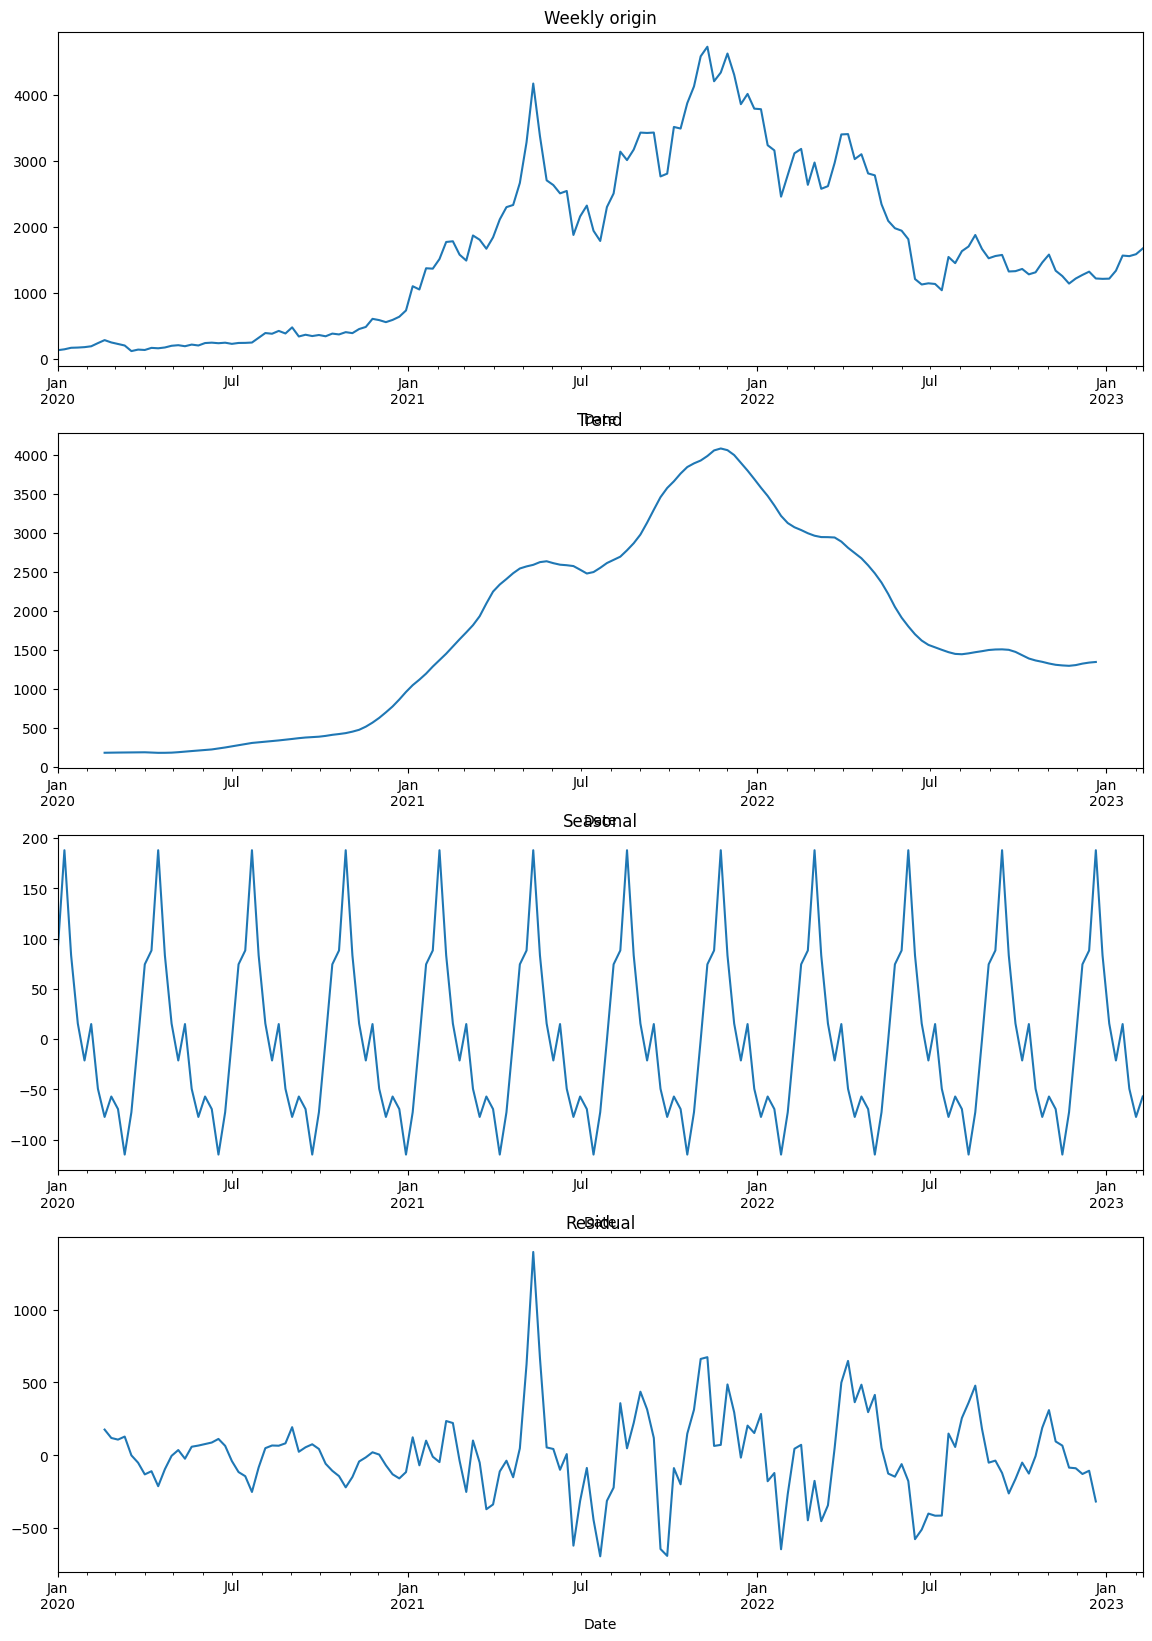

In [49]:
figure, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))
decomposed = seasonal_decompose(weekly_resampled_df[['Opening']], period=14)
ax[0].set_title('Weekly origin')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decomposed.observed.plot(ax=ax[0])
decomposed.trend.plot(ax=ax[1])
decomposed.seasonal.plot(ax=ax[2])
decomposed.resid.plot(ax=ax[3])

***Get rid of the trend***


*Differencing*

In [50]:
weekly_resampled_df['Opening_diff'] = weekly_resampled_df['Opening'].diff()
N = 13
weekly_resampled_df['Opening_diff_N'] = weekly_resampled_df['Opening'].diff(periods=N)
weekly_resampled_df.head(10)

,Opening,Opening_diff,Opening_diff_N
Date,,,
2020-01-01,129.21,NaN,NaN
2020-01-08,143.01,13.80,NaN
2020-01-15,166.07,23.06,NaN
2020-01-22,169.41,3.34,NaN
2020-01-29,175.78,6.37,NaN
2020-02-05,188.94,13.16,NaN
2020-02-12,236.75,47.81,NaN
2020-02-19,282.33,45.58,NaN
2020-02-26,246.97,-35.36,NaN


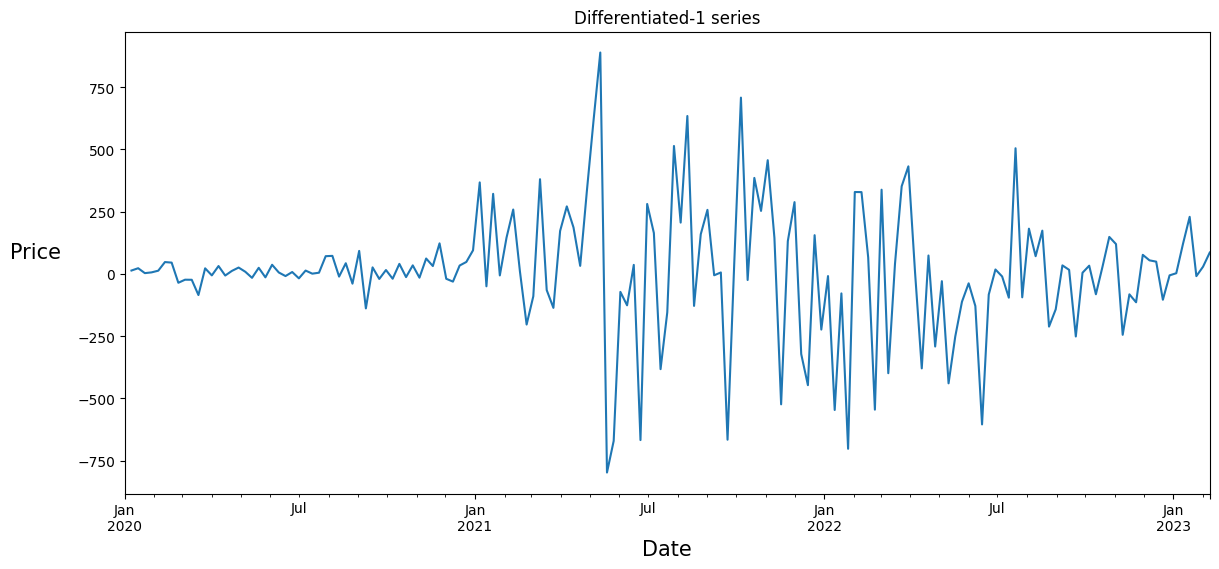

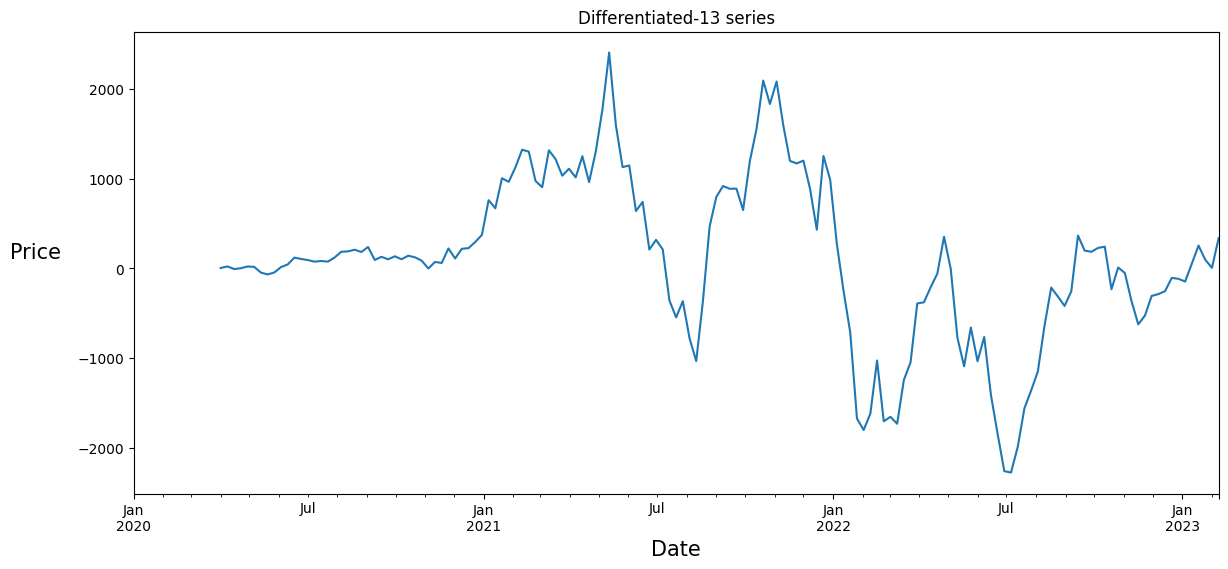

In [51]:
draw_plot_price(weekly_resampled_df['Opening_diff'], 'Differentiated-1 series')
draw_plot_price(weekly_resampled_df['Opening_diff_N'], 'Differentiated-' + str(N) + ' series')

*Add taking logarithm of the series*

In [52]:
weekly_resampled_df['Opening_log'] = np.log(weekly_resampled_df['Opening'])
weekly_resampled_df['Opening_logDiff'] = weekly_resampled_df['Opening_log'].diff()
weekly_resampled_df['Opening_logDiff_N'] = weekly_resampled_df['Opening_log'].diff(periods=N)
weekly_resampled_df.head(10)

,Opening,Opening_diff,Opening_diff_N,Opening_log,Opening_logDiff,Opening_logDiff_N
Date,,,,,,
2020-01-01,129.21,NaN,NaN,4.861439,NaN,NaN
2020-01-08,143.01,13.80,NaN,4.962915,0.101476,NaN
2020-01-15,166.07,23.06,NaN,5.112409,0.149495,NaN
2020-01-22,169.41,3.34,NaN,5.132322,0.019912,NaN
2020-01-29,175.78,6.37,NaN,5.169233,0.036911,NaN
2020-02-05,188.94,13.16,NaN,5.241430,0.072196,NaN
2020-02-12,236.75,47.81,NaN,5.467005,0.225575,NaN
2020-02-19,282.33,45.58,NaN,5.643077,0.176072,NaN
2020-02-26,246.97,-35.36,NaN,5.509267,-0.133810,NaN


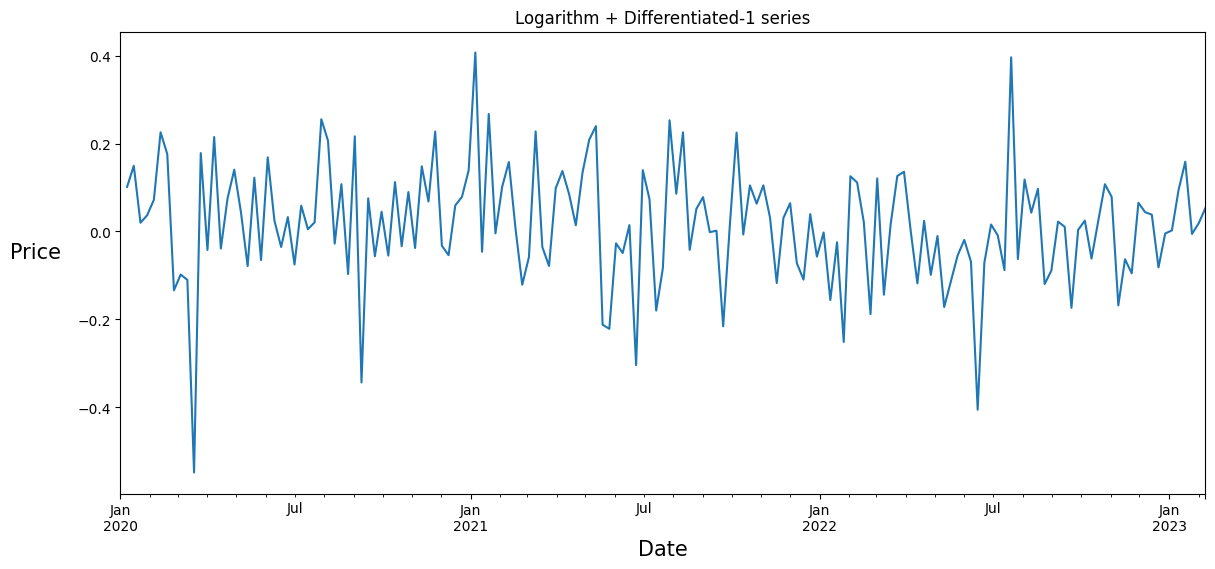

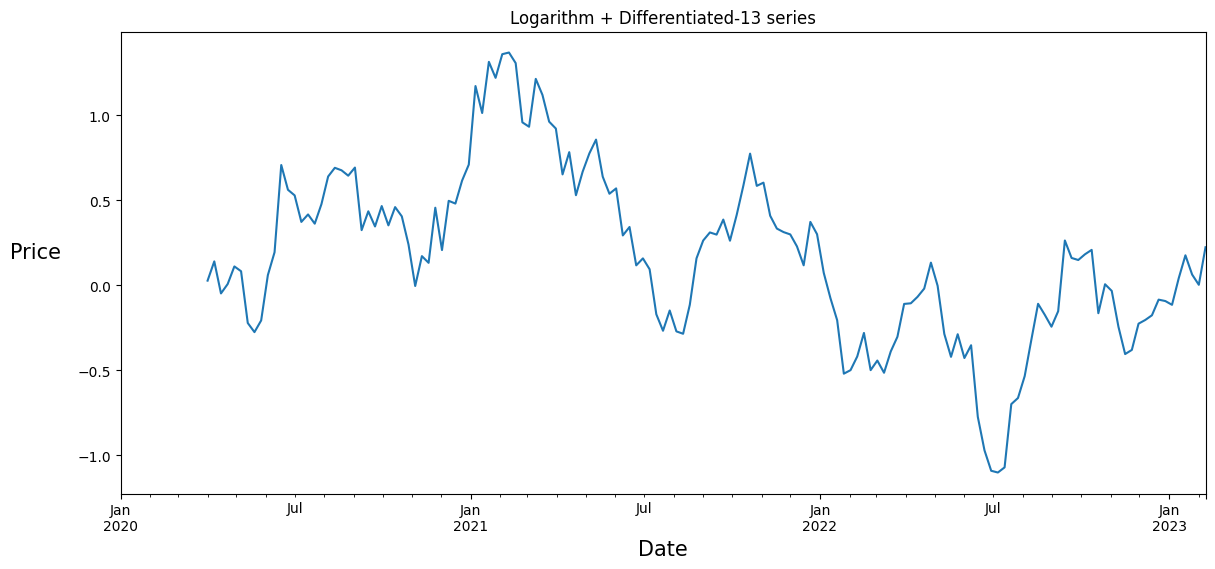

In [53]:
draw_plot_price(weekly_resampled_df['Opening_logDiff'], 'Logarithm + Differentiated-1 series')
draw_plot_price(weekly_resampled_df['Opening_logDiff_N'], 'Logarithm + Differentiated-' + str(N) + ' series')

***Stationary test***

*Method prints result Dicky-Fuller test*

In [54]:
def print_adfuller_result(value, name):
    print(
        f'Полученный уровень значимости {name} (p-value): {value}.',
        (f'{value} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен' if (
                value > 0.05) else
         f'{value} < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной! Ряд стационарен')
    )

In [55]:
col_names = ['Opening', 'Opening_diff', 'Opening_diff_N', 'Opening_log', 'Opening_logDiff', 'Opening_logDiff_N']
map_name_res = set(
    map(lambda name: (adfuller(weekly_resampled_df[name][(N if (name[-1] == 'N') else 1):])[1], name), col_names))
for pair in map_name_res:
    print(str(pair[1]) + ": ", end='')
    print_adfuller_result(round(pair[0], 5), pair[1])
print('=================')

print('Best result shown by ', end='')
best = min(map_name_res)
print(best)

Opening_diff_N: Полученный уровень значимости Opening_diff_N (p-value): 0.5958. 0.5958 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен
Opening: Полученный уровень значимости Opening (p-value): 0.47573. 0.47573 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен
Opening_diff: Полученный уровень значимости Opening_diff (p-value): 0.02502. 0.02502 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной! Ряд стационарен
Opening_logDiff: Полученный уровень значимости Opening_logDiff (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной! Ряд стационарен
Opening_log: Полученный уровень значимости Opening_log (p-value): 0.30216. 0.30216 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен
Opening_logDiff_N: Полученный уровень значимости Opening_logDiff_N (p-value): 0.68992. 0.68992 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд не стационарен
Best r

*Save in 'weekly_resampled_df' only origin data and transform with best result*

In [56]:
weekly_resampled_df.head()

,Opening,Opening_diff,Opening_diff_N,Opening_log,Opening_logDiff,Opening_logDiff_N
Date,,,,,,
2020-01-01,129.21,NaN,NaN,4.861439,NaN,NaN
2020-01-08,143.01,13.80,NaN,4.962915,0.101476,NaN
2020-01-15,166.07,23.06,NaN,5.112409,0.149495,NaN
2020-01-22,169.41,3.34,NaN,5.132322,0.019912,NaN
2020-01-29,175.78,6.37,NaN,5.169233,0.036911,NaN


In [57]:
weekly_resampled_df.head()

,Opening,Opening_diff,Opening_diff_N,Opening_log,Opening_logDiff,Opening_logDiff_N
Date,,,,,,
2020-01-01,129.21,NaN,NaN,4.861439,NaN,NaN
2020-01-08,143.01,13.80,NaN,4.962915,0.101476,NaN
2020-01-15,166.07,23.06,NaN,5.112409,0.149495,NaN
2020-01-22,169.41,3.34,NaN,5.132322,0.019912,NaN
2020-01-29,175.78,6.37,NaN,5.169233,0.036911,NaN


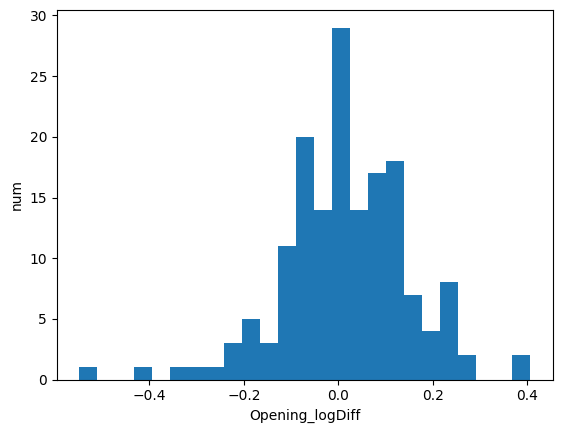

In [58]:
plt.xlabel(best[1])
plt.ylabel('num')
plt.hist(weekly_resampled_df[best[1]], bins=25)
plt.show()

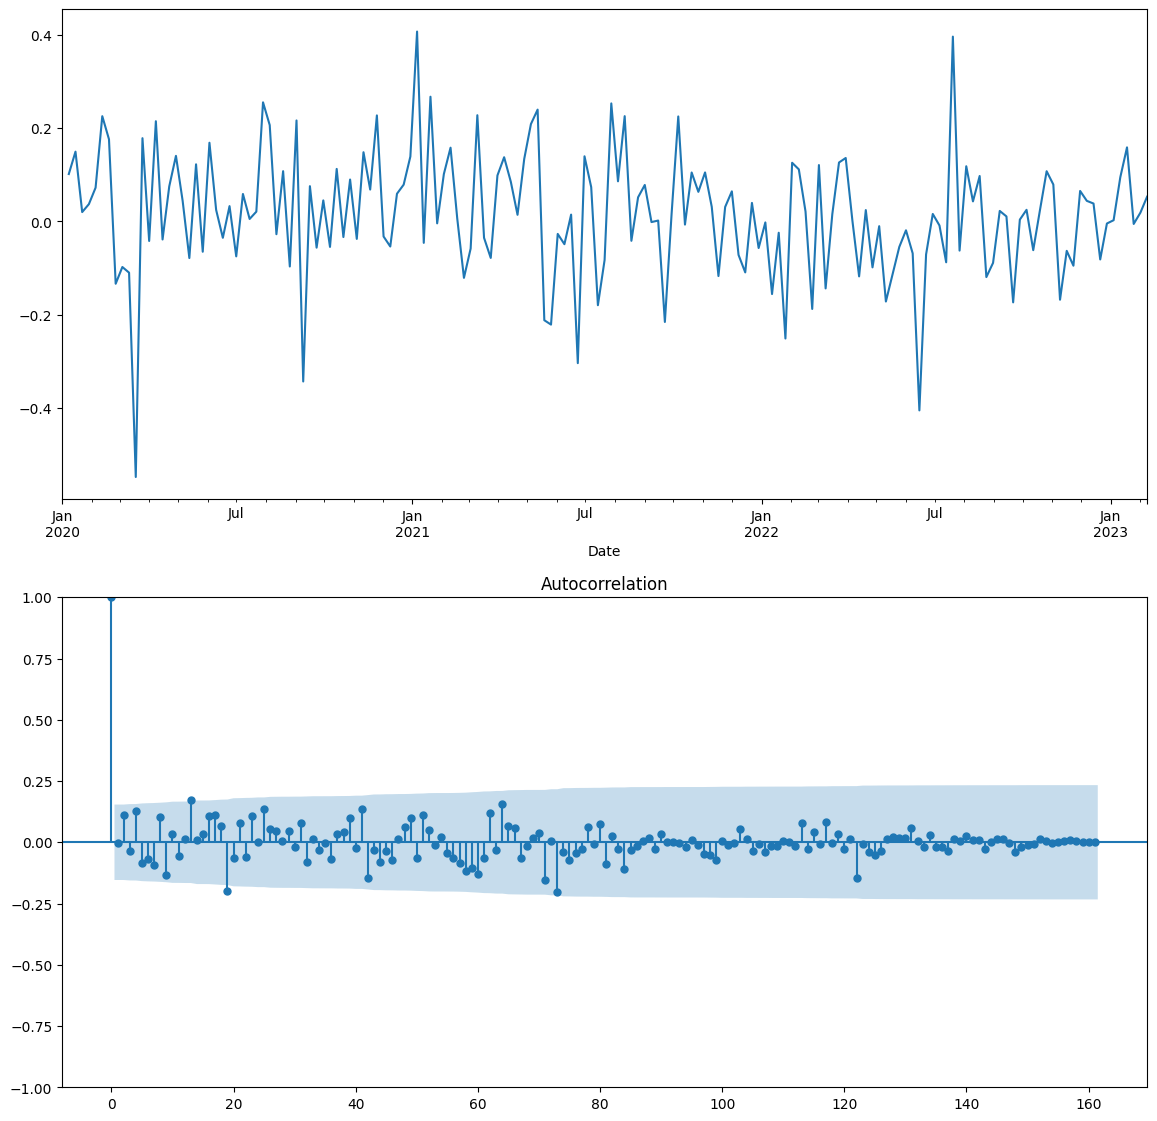

In [59]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
weekly_resampled_df[best[1]].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(weekly_resampled_df[best[1]][1:], lags=weekly_resampled_df.__len__() - 2, ax=ax);

In [60]:
d = 1
D = 1
qs = range(1, 5)
Qs = range(1, 3)
ps = range(1, 5)
Ps = range(1, 3)
S = 13
# 52/4=13 in quart

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [61]:
def choose_best_params(data, parameters_list):
    length = data.shape[0] - 1
    train_length = int(length * 0.8)

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(
                data[1:1 + train_length],
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], S)
            ).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return best_model, train_length, results, best_aic, best_param

*Find the best parameters for Sarima*

In [62]:
import warnings

warnings.filterwarnings("ignore")

lib_model, train_length_lib, results_1, aic_lib, best_params = choose_best_params(
    weekly_resampled_df['Opening_logDiff'], parameters_list)

100%|██████████| 64/64 [02:46<00:00,  2.60s/it]


In [63]:
print(f'best parameters for lib model: {best_params}')
print(f'best AIC for lib model: {aic_lib}')


best parameters for lib model: (1, 2, 1, 2)
best AIC for lib model: -101.33070410208542


In [64]:
test_length_lib = weekly_resampled_df['Opening_logDiff'].shape[0] - 1 - train_length_lib
fitted = lib_model.fittedvalues
weekly_resampled_df['Predicted_lib_train'] = lib_model.fittedvalues
weekly_resampled_df['Predicted_lib_test'] = lib_model.predict(start=train_length_lib,
                                                              end=train_length_lib + test_length_lib - 1)

<Axes: xlabel='Date'>

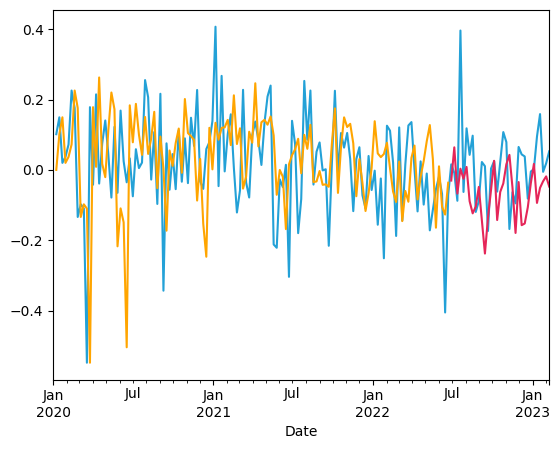

In [65]:
weekly_resampled_df['Opening_logDiff'].plot(label='origin', c=color_for_origin)
weekly_resampled_df['Predicted_lib_train'].plot(label='train', c=color_for_train)
weekly_resampled_df['Predicted_lib_test'].plot(label='test', c=color_for_test)

In [66]:
weekly_resampled_df['predicted_sarima'] = weekly_resampled_df['Predicted_lib_train'].combine_first(
    weekly_resampled_df['Predicted_lib_test'])

weekly_resampled_df['predicted_sarima_real'] = SarimaInteractor.inverse_diff(weekly_resampled_df['Opening_log'].iloc[0],
                                                                             weekly_resampled_df[
                                                                                 'predicted_sarima'].iloc[1:], 1, True)
weekly_resampled_df['predicted_sarima_train_real'] = weekly_resampled_df['predicted_sarima_real'].iloc[
                                                     :train_length_lib + 1]
weekly_resampled_df['predicted_sarima_test_real'] = weekly_resampled_df['predicted_sarima_real'].iloc[
                                                    train_length_lib + 1:]

<Axes: xlabel='Date'>

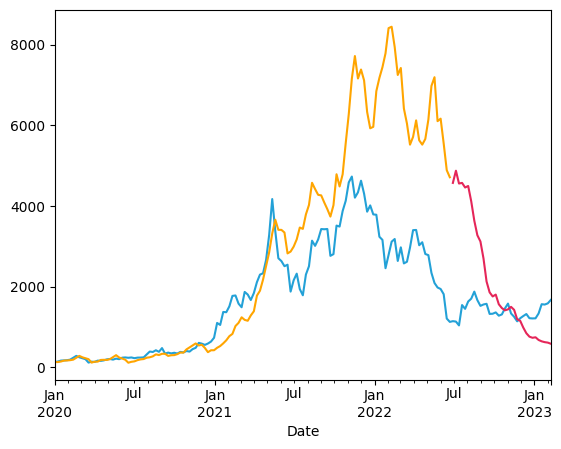

In [67]:
weekly_resampled_df['Opening'].plot(label='Origin', c=color_for_origin)
weekly_resampled_df['predicted_sarima_train_real'].plot(label='train lib model', c=color_for_train)
weekly_resampled_df['predicted_sarima_test_real'].plot(label='test lib model', c=color_for_test)

In [68]:
print(lib_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Opening_logDiff   No. Observations:                  129
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 13)   Log Likelihood                  57.665
Date:                            Mon, 23 Oct 2023   AIC                           -101.331
Time:                                    08:43:28   BIC                            -82.116
Sample:                                01-08-2020   HQIC                           -93.532
                                     - 06-22-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9317      0.100     -9.319      0.000      -1.128      -0.736
ma.L1         -0.0883      0.141   

 **Implemented Sarima**

In [69]:
data = weekly_resampled_df['Opening_logDiff'][1:]

aic=71.31733450586313


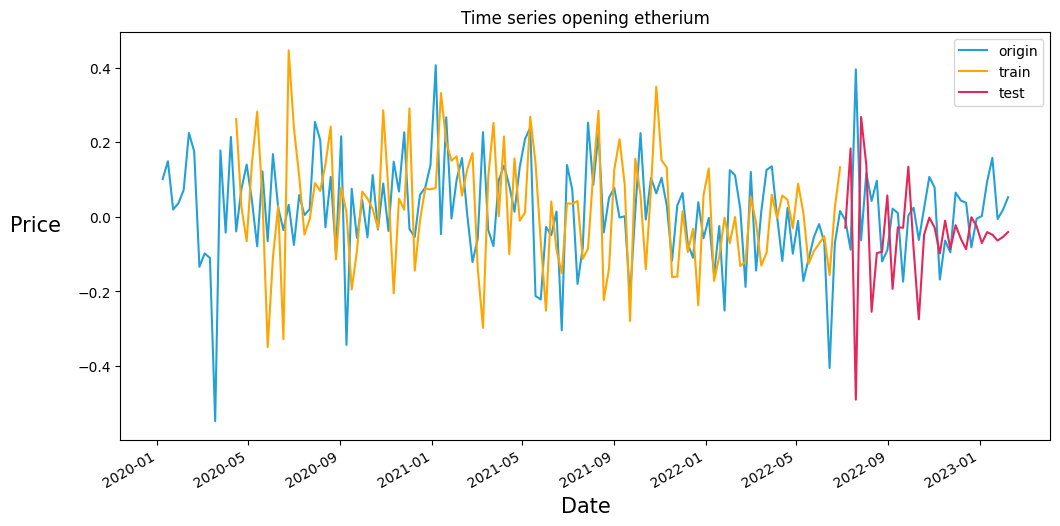

In [70]:
from interactor.sarima_interactor import SarimaInteractor

sarima_interactor = SarimaInteractor(data, (best_params[0], d, best_params[1]),
                                     (best_params[2], D, best_params[3], S))

weekly_resampled_df['predictedImpl_train'] = sarima_interactor.get_train_predicts()
print(f'aic={sarima_interactor.model_aic()}')
weekly_resampled_df['predictedImpl_test'] = sarima_interactor.get_test_predicts()

data_len = len(data)

plt.figure(figsize=(12, 6))
plt.title('Time series opening etherium')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
plt.plot(data, label='origin', c=light_blue_color)
weekly_resampled_df['predictedImpl_train'].plot(label='train', c='orange')
weekly_resampled_df['predictedImpl_test'].plot(label='test', c=pink_red_color)
plt.legend()
plt.show()


In [71]:
weekly_resampled_df['predictedImpl'] = sarima_interactor.get_all_predicts()
sarima_interactor.recover_to_origin(weekly_resampled_df['Opening'], weekly_resampled_df['Opening_log'])
weekly_resampled_df['predictedImpl_recovered'] = sarima_interactor.recovered_preds
weekly_resampled_df['predictedImpl_train_recovered'] = sarima_interactor.recovered_preds_train
weekly_resampled_df['predictedImpl_test_recovered'] = sarima_interactor.recovered_preds_test
print(weekly_resampled_df['predictedImpl_recovered'])

Date
2020-01-01    129.210000
2020-01-08    143.010000
2020-01-15    166.070000
2020-01-22    169.410000
2020-01-29    175.780000
                 ...    
2023-01-11    371.897574
2023-01-18    354.567715
2023-01-25    332.803710
2023-02-01    315.337929
2023-02-08    302.847219
Freq: 7D, Name: predictedImpl_recovered, Length: 163, dtype: float64


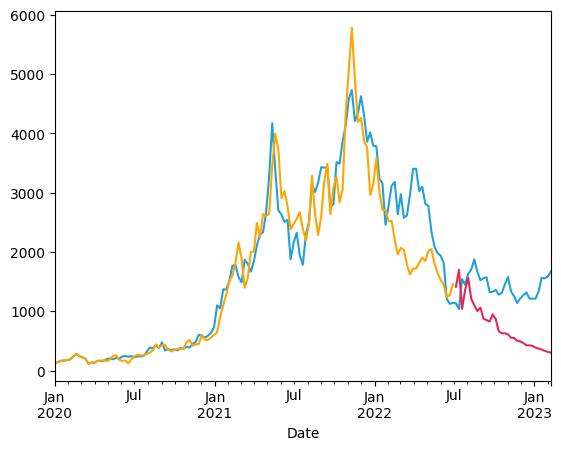

In [72]:
weekly_resampled_df['Opening'].plot(label='origin', c=color_for_origin)
weekly_resampled_df['predictedImpl_train_recovered'].plot(label='train', c=color_for_train)
weekly_resampled_df['predictedImpl_test_recovered'].plot(label='test', c=color_for_test)
plt.show()

In [73]:
import sklearn.metrics as skm
from prettytable import PrettyTable


def smape(real, preds):
    return 100 / len(real) * np.sum(2 * np.abs(real - preds) / (np.abs(real) + np.abs(preds)))


table = PrettyTable()
table.field_names = ['Metric', 'SarimaLib', 'SarimaImpl']
metrics = [(skm.mean_absolute_error, 'MAE'), (skm.mean_absolute_percentage_error, 'MAPE'), (smape, 'SMAPE'),
           (skm.mean_squared_log_error, 'MSLE'),
           (skm.mean_gamma_deviance, 'MGDev')]

for metric, name in metrics:
    lib = metric(weekly_resampled_df['Opening'], weekly_resampled_df['predicted_sarima_real'])
    impl = metric(weekly_resampled_df['Opening'], weekly_resampled_df['predictedImpl_recovered'])
    table.add_row([name, '{lib:.4f}'.format(lib=lib), '{impl:.4f}'.format(impl=impl)])



**Sarima vs SarimaImpl**

In [74]:
print(table)


+--------+-----------+------------+
| Metric | SarimaLib | SarimaImpl |
+--------+-----------+------------+
|  MAE   | 1197.4990 |  380.9751  |
|  MAPE  |   0.6028  |   0.2174   |
| SMAPE  |  42.7592  |  26.5786   |
|  MSLE  |   0.3294  |   0.1944   |
| MGDev  |   0.2863  |   0.2893   |
+--------+-----------+------------+
